## CS 871 Machine Learning (Project)

## MNIST Digit Classification Machine Learning Project

The MNIST digit classification python project enables machines to recognize handwritten digits. Convolutional Neural Network has been used for implementing the classification algorithm.

A two layer CNN architecture (as proposed by http://yann.lecun.com/exdb/mnist/) also commonly known as 'LeNet' is implemented and trained on existing MNIST digits dataset. The test dataset is evaluated on the corresponding trained model and the results show very high accuracy.

Afer testing the model performance on original test dataset, images of the test dataset have been modified slightly by exposing it to slight transformations (rotation, translation, scaling, brightness variation) to make the dataset more representative of images to be encountered in real world (not especially curated dataset). It is observed that the accuracy of the model reduces significantly which shows that existing model does not generalize good enough for the real world images since these transformations are common in real life. 

The same model was then again trained on the same training dataset. However, this time data augmentation has been used to overcome the overfitting of the model. The results show that the newly trained model now performs significantly better and achieves higher accuracy which shows the effectiveness of data augmentation during training.

## Import Requisite Modules

In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, ReLU, Input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import os
%matplotlib inline

## Dataset Preprocessing

Execute the following block to download the MNIST dataset and preprocess it for the model training

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11501568/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


In [9]:
def DisplayImages(x_train):
    NoOfImageRows = 3
    j=0
    for i in range(len(x_train)):
        j = j+1
        if j>NoOfImageRows*3: break
        plt.subplot(NoOfImageRows,3,i+1)
        img = x_train[i]
        img = np.squeeze(img, axis=2)
        plt.imshow(img, cmap='gray')
        # plt.title('Pred '+str(predictedLabels[indexes[i]]) + ' GT '+ str(groundTruthLabels[indexes[i]]))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    plt.show()

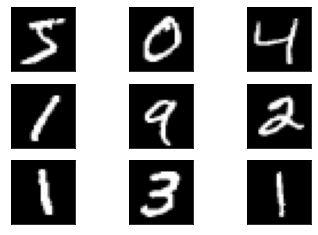

In [10]:
DisplayImages(x_train)

## Support functions for building the CNN-based classifier

In [ ]:
def BuildLeNet():
    inputImg = Input(shape =(28,28,1), name = 'inputLayer')
    x = Conv2D(filters=20,kernel_size=(5,5), strides=(1,1),padding='same', activation='relu', name = 'ConvLayer_1_5x5_20')(inputImg)
    x = MaxPool2D(pool_size=(2,2),strides=2, name = 'MaxPoolLayer_1_2x2')(x)
    x = Conv2D(filters=50,kernel_size=(5,5), strides=(1,1),padding='same', activation='relu', name = 'ConvLayer_2_5x5_50')(x)
    x = MaxPool2D(pool_size=(2,2),strides=2, name = 'MaxPoolLayer_2_2x2')(x)
    x = Flatten(name = 'FlattenLayer')(x)
#     x = GlobalAveragePooling2D(name = 'GlobalAveragePooling_LeNet')(x)
    x = Dense(units= 500, activation = 'relu', name = 'DenseLayer_1_500')(x)
    x = Dense(units= 10, activation = 'softmax', name = 'SoftmaxLayer_10')(x)
    model = Model(inputs = inputImg, outputs = x)
    return model

In [ ]:
model = BuildLeNet()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics ='accuracy')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 ConvLayer_1_5x5_20 (Conv2D)  (None, 28, 28, 20)       520       
                                                                 
 MaxPoolLayer_1_2x2 (MaxPool  (None, 14, 14, 20)       0         
 ing2D)                                                          
                                                                 
 ConvLayer_2_5x5_50 (Conv2D)  (None, 14, 14, 50)       25050     
                                                                 
 MaxPoolLayer_2_2x2 (MaxPool  (None, 7, 7, 50)         0         
 ing2D)                                                          
                                                                 
 FlattenLayer (Flatten)      (None, 2450)              0     

## Plot the model architecture

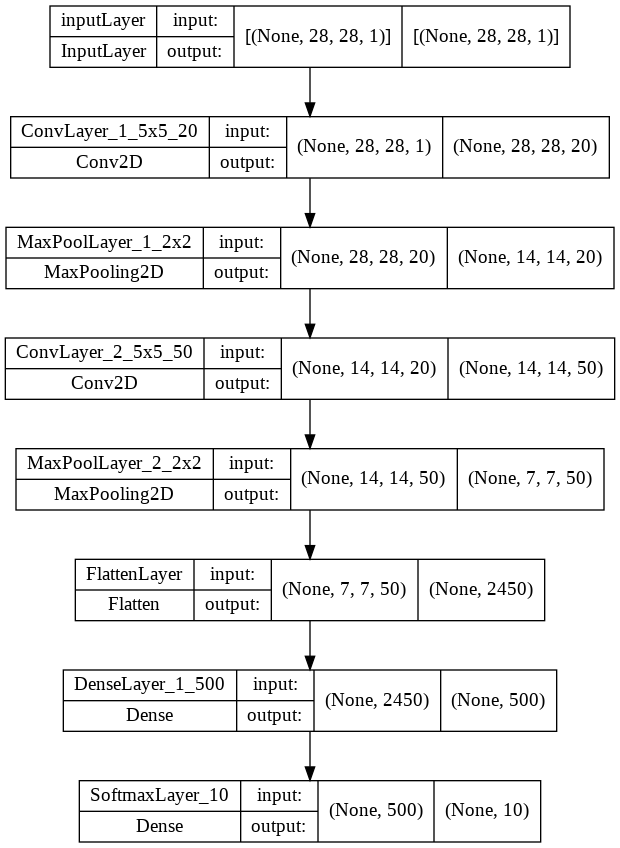

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Support Functions for model Evaluation

In [ ]:
# This function is used for plotting the training progress of the model
def PlotTrainingGraph(history, graphType):
    trainingValue = history.history[graphType]
    validationValue = history.history['val_'+graphType]
    plot_epochs = range(1, len(trainingValue)+1)

    plt.plot(plot_epochs, trainingValue, 'r', label='Training')
    plt.plot(plot_epochs, validationValue, 'b', label='Validation')
    plt.title('Model Training Graph ' + graphType)
    plt.ylabel(graphType)  #Y-axis label
    plt.xlabel('epoch')  #X-axis label
    plt.legend()
    plt.show()
# This function is used for printing Confusion Matrix     
def DisplayConfusions(labelsY, predictions,class_names):
    confMat = confusion_matrix(labelsY, predictions)
#     print(confMat)
    plt.rcParams["figure.figsize"] = (14,7)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=class_names)
    disp.plot(xticks_rotation = 90)
    plt.show()
# This function is used for generating model evaluation report according to metrics         
def GenerateModelAccurayMetrics():
    groundTruthLabels = np.argmax(y_test, axis=1)
    predictedLabels = np.argmax(predictions, axis=1)
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    accuracy = accuracy_score(groundTruthLabels, predictedLabels)
    classificationReport = classification_report(groundTruthLabels,predictedLabels,target_names=class_names)

    print('Accuracy of the trained model is '+str(accuracy))
    print(classificationReport)
    DisplayConfusions(groundTruthLabels, predictedLabels,class_names)
    a = groundTruthLabels==predictedLabels
    wronglyClassifiedIndexes = np.where(a==False)[0]
    correctlyClassifiedIndexes = np.where(a==True)[0]
    return wronglyClassifiedIndexes, correctlyClassifiedIndexes
# This function is used for displaying predicted images
def DisplayPredictedImages(indexes, NoOfImageRows):
    groundTruthLabels = np.argmax(y_test, axis=1)
    predictedLabels = np.argmax(predictions, axis=1)
    j=0
    for i in range(len(indexes)):
        j = j+1
        if j>NoOfImageRows*3: break
        plt.subplot(NoOfImageRows,3,i+1)
        img = x_test[indexes[i]]
        img = np.squeeze(img, axis=2)
        plt.imshow(img, cmap='gray')
        plt.title('Pred '+str(predictedLabels[indexes[i]]) + ' GT '+ str(groundTruthLabels[indexes[i]]))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    plt.show()

## Train the model (without data augmentation)

In [ ]:
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.1)
history = model.fit(datagen.flow(x_train, y_train, batch_size=64, subset='training', seed = 150),
         validation_data=datagen.flow(x_train, y_train, batch_size=64, subset='validation'), epochs=15)

Epoch 1/10
844/844 [==============================] - 16s 6ms/step - loss: 0.1267 - accuracy: 0.9595 - val_loss: 0.0576 - val_accuracy: 0.9830
Epoch 2/10
844/844 [==============================] - 5s 6ms/step - loss: 0.0379 - accuracy: 0.9887 - val_loss: 0.0335 - val_accuracy: 0.9913
Epoch 3/10
844/844 [==============================] - 5s 6ms/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0369 - val_accuracy: 0.9905
Epoch 4/10
844/844 [==============================] - 5s 6ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0529 - val_accuracy: 0.9895
Epoch 5/10
844/844 [==============================] - 5s 6ms/step - loss: 0.0147 - accuracy: 0.9957 - val_loss: 0.0486 - val_accuracy: 0.9900
Epoch 6/10
844/844 [==============================] - 5s 6ms/step - loss: 0.0111 - accuracy: 0.9969 - val_loss: 0.0578 - val_accuracy: 0.9898
Epoch 7/10
844/844 [==============================] - 5s 6ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.0451 - val_accuracy: 0.9893
Epoch

## Plot Training Graphs

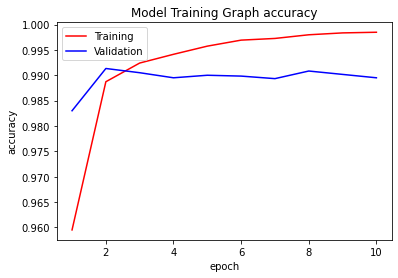

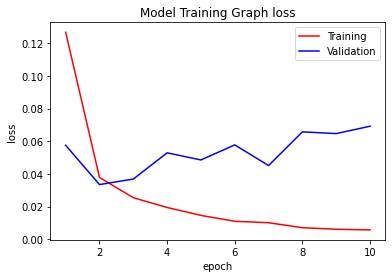

In [ ]:
PlotTrainingGraph(history, 'accuracy')
PlotTrainingGraph(history, 'loss')

## Evaluate the Model (Original Dataset)

In [ ]:
datagen=ImageDataGenerator(rescale=1./255)
predictions = model.predict(datagen.flow(x_test, y_test, batch_size=64, shuffle= False), verbose = 1)

157/157 [==============================] - 1s 4ms/step


Accuracy of the trained model is 0.9921
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



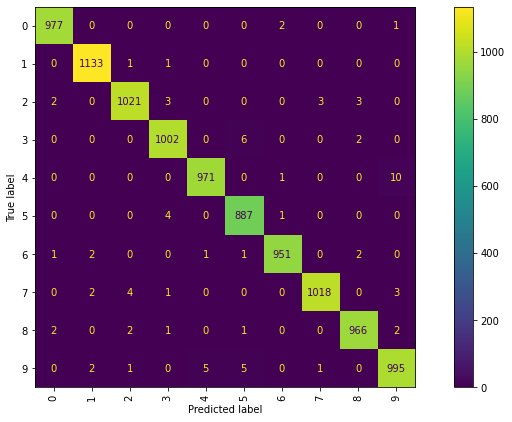


------------------------------ Correctly Predicted Images ------------------------------


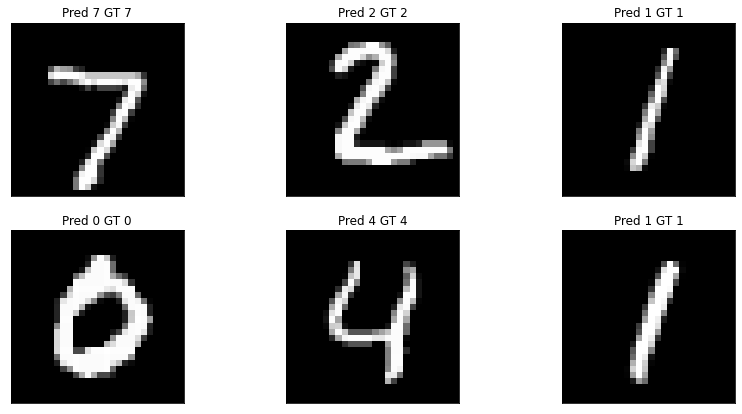


------------------------------ Wrongly Predicted Images ------------------------------


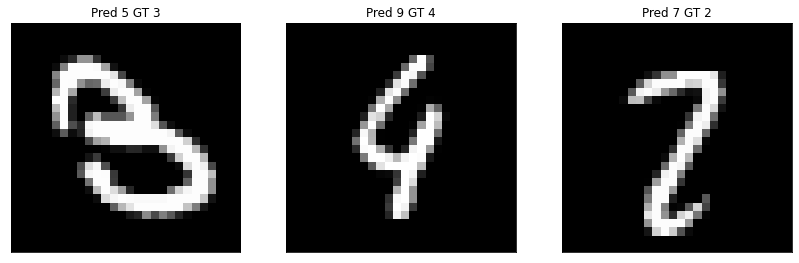

In [ ]:
wronglyClassifiedIndexes, correctlyClassifiedIndexes = GenerateModelAccurayMetrics()
print('\n------------------------------ Correctly Predicted Images ------------------------------')
DisplayPredictedImages(correctlyClassifiedIndexes, 2)
print('\n------------------------------ Wrongly Predicted Images ------------------------------')
DisplayPredictedImages(wronglyClassifiedIndexes, 1)

## Evaluate the Model (Modified Dataset exposed to different transformations)

In [ ]:
datagen=ImageDataGenerator(rescale=1./255, rotation_range=25, width_shift_range=0.3,
    height_shift_range=0.3, brightness_range=[0.7,1.3], zoom_range=0.4, fill_mode='nearest')
predictions = model.predict(datagen.flow(x_test, y_test, batch_size=64, shuffle= False), verbose = 1)

157/157 [==============================] - 5s 30ms/step


Accuracy of the trained model is 0.2776
              precision    recall  f1-score   support

           0       0.34      0.18      0.24       980
           1       0.37      0.26      0.30      1135
           2       0.21      0.35      0.26      1032
           3       0.42      0.31      0.36      1010
           4       0.30      0.28      0.29       982
           5       0.27      0.35      0.30       892
           6       0.22      0.32      0.26       958
           7       0.24      0.38      0.29      1028
           8       0.30      0.18      0.22       974
           9       0.31      0.18      0.23      1009

    accuracy                           0.28     10000
   macro avg       0.30      0.28      0.28     10000
weighted avg       0.30      0.28      0.28     10000



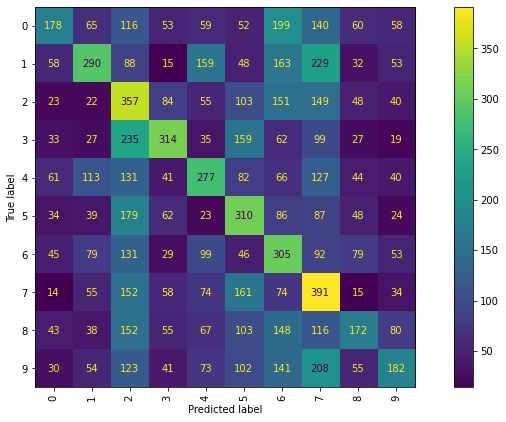


------------------------------ Correctly Predicted Images ------------------------------


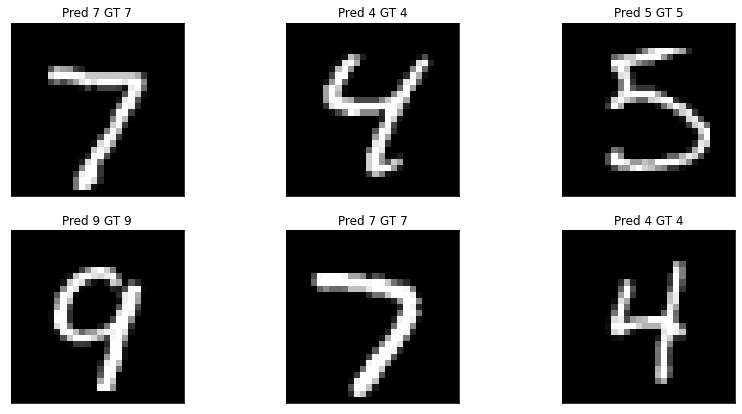


------------------------------ Wrongly Predicted Images ------------------------------


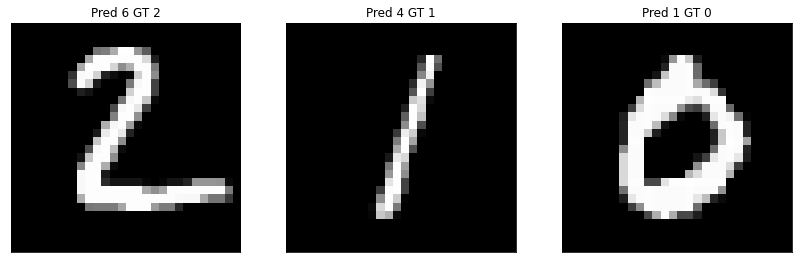

In [ ]:
wronglyClassifiedIndexes, correctlyClassifiedIndexes = GenerateModelAccurayMetrics()
print('\n------------------------------ Correctly Predicted Images ------------------------------')
DisplayPredictedImages(correctlyClassifiedIndexes, 2)
print('\n------------------------------ Wrongly Predicted Images ------------------------------')
DisplayPredictedImages(wronglyClassifiedIndexes, 1)

## Train Model with data augmentation

In [ ]:
datagen=ImageDataGenerator(rescale=1./255, rotation_range=25, width_shift_range=0.3,height_shift_range=0.3, 
                           brightness_range=[0.7,1.3], zoom_range=0.4, fill_mode='nearest', validation_split=0.1)
history = model.fit(datagen.flow(x_train, y_train, batch_size=64, subset='training', seed=150),
         validation_data=datagen.flow(x_train, y_train, batch_size=64, subset='validation'), epochs=15)

Epoch 1/10
844/844 [==============================] - 30s 35ms/step - loss: 0.9743 - accuracy: 0.6963 - val_loss: 0.4948 - val_accuracy: 0.8433
Epoch 2/10
844/844 [==============================] - 30s 35ms/step - loss: 0.4081 - accuracy: 0.8739 - val_loss: 0.3487 - val_accuracy: 0.8955
Epoch 3/10
844/844 [==============================] - 29s 35ms/step - loss: 0.3269 - accuracy: 0.9002 - val_loss: 0.3215 - val_accuracy: 0.9075
Epoch 4/10
844/844 [==============================] - 31s 36ms/step - loss: 0.2911 - accuracy: 0.9089 - val_loss: 0.2733 - val_accuracy: 0.9195
Epoch 5/10
844/844 [==============================] - 30s 35ms/step - loss: 0.2691 - accuracy: 0.9172 - val_loss: 0.2580 - val_accuracy: 0.9178
Epoch 6/10
844/844 [==============================] - 32s 38ms/step - loss: 0.2557 - accuracy: 0.9221 - val_loss: 0.2582 - val_accuracy: 0.9193
Epoch 7/10
844/844 [==============================] - 31s 36ms/step - loss: 0.2463 - accuracy: 0.9243 - val_loss: 0.2394 - val_accuracy:

## Plot Training Graphs

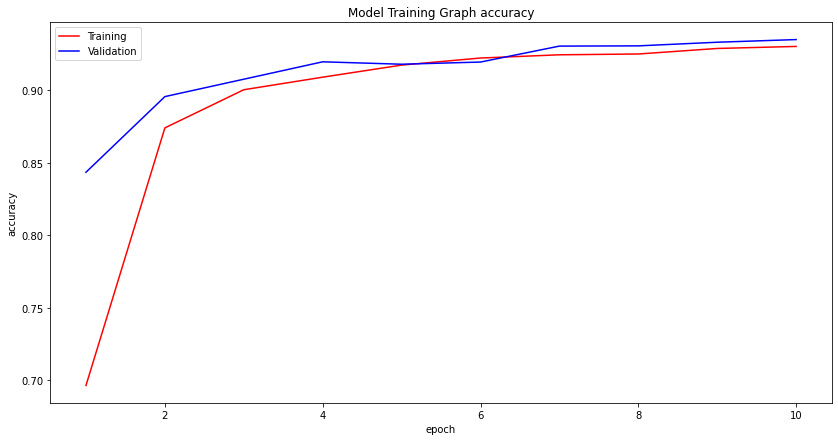

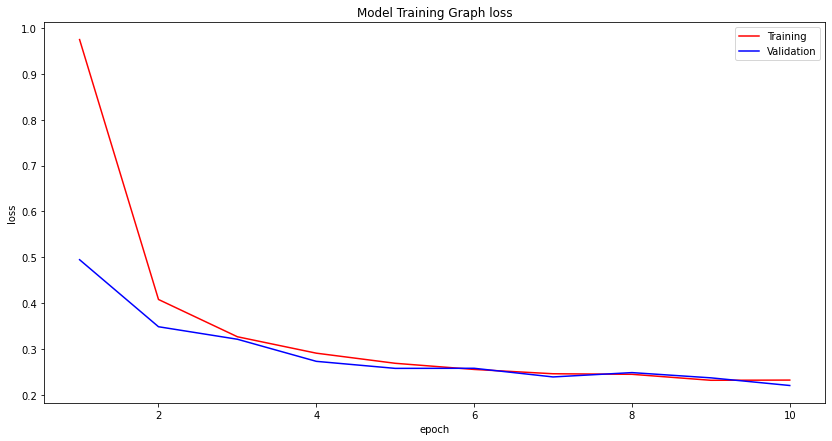

In [ ]:
PlotTrainingGraph(history, 'accuracy')
PlotTrainingGraph(history, 'loss')

## Evaluate the Model trained with data augmentation

In [ ]:
datagen=ImageDataGenerator(rescale=1./255, rotation_range=25, width_shift_range=0.3,
    height_shift_range=0.3, brightness_range=[0.7,1.3], zoom_range=0.4, fill_mode='nearest')
predictions = model.predict(datagen.flow(x_test, y_test, batch_size=64, shuffle= False), verbose = 1)

157/157 [==============================] - 5s 29ms/step


Accuracy of the trained model is 0.937
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.95      0.99      0.97      1135
           2       0.94      0.92      0.93      1032
           3       0.96      0.92      0.94      1010
           4       0.93      0.95      0.94       982
           5       0.90      0.94      0.92       892
           6       0.91      0.96      0.93       958
           7       0.93      0.91      0.92      1028
           8       0.97      0.91      0.94       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



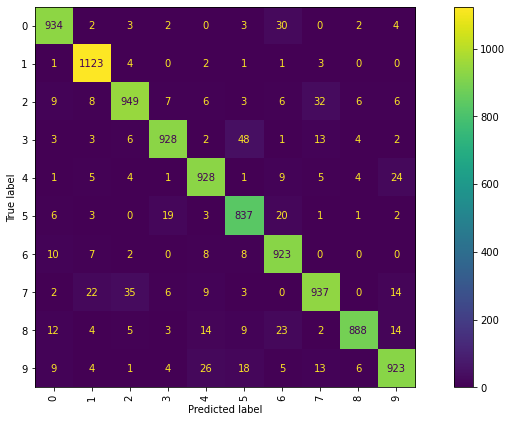


------------------------------ Correctly Predicted Images ------------------------------


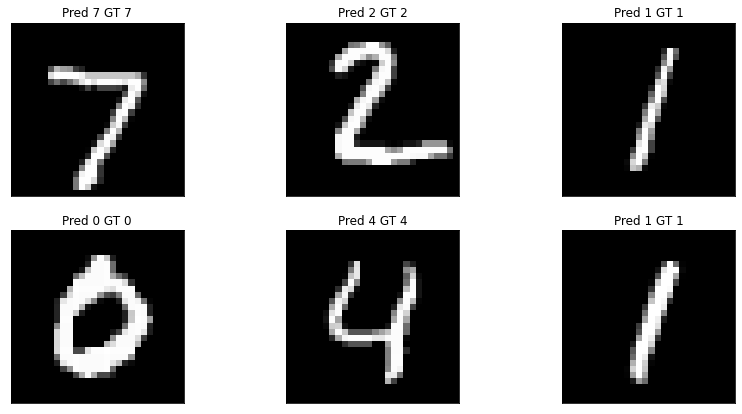


------------------------------ Wrongly Predicted Images ------------------------------


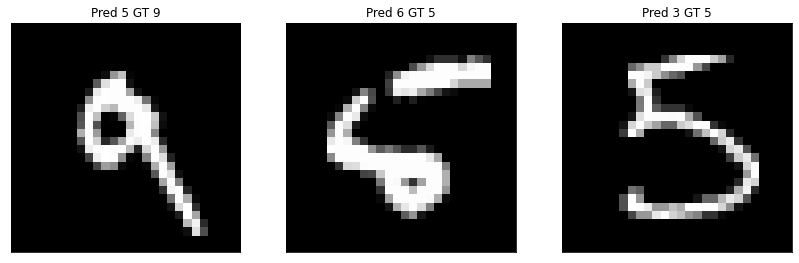

In [ ]:
wronglyClassifiedIndexes, correctlyClassifiedIndexes = GenerateModelAccurayMetrics()
print('\n------------------------------ Correctly Predicted Images ------------------------------')
DisplayPredictedImages(correctlyClassifiedIndexes, 2)
print('\n------------------------------ Wrongly Predicted Images ------------------------------')
DisplayPredictedImages(wronglyClassifiedIndexes, 1)